In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm

### Discriminator

In [11]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    # features_d is the number of channels that we are gonna process
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # Input: N x channels_img x 64 x 64
        nn.Conv2d(
            channels_img, features_d, kernel_size=4, stride=2, padding=1
        ), # 32 x 32
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d*2, 4, 2, 1), #16x16
        self._block(features_d*2, features_d*4, 4, 2, 1), # 8x8
        self._block(features_d*4, features_d*8, 4, 2, 1), # 4x4
        nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1x1
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.InstanceNorm2d(out_channels, affine=True), # LayerNorm <-> InstanceNorm
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

### Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        # features_d is the number of channels that we are gonna process
        # z_dim is the dimension of the noise vector
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x feature_g x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), # N x features_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # N x features_g*8 x 8 x 8
            self._block(features_g*8, features_g*4, 4, 2, 1), # N x features_g*4 x 16 x 16
            self._block(features_g*4, features_g*2, 4, 2, 1), # N x features_g*2 x 32 x 32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(), # [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )


### Initialize Weights

In [13]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)


In [14]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels, 8)
  assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
  gen = Generator(z_dim, in_channels, 8)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
  print("Success")

test()

Success


### Gradient Penalty

In [15]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

### Hyper Parameters

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# comment mnist above and uncomment below for training on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

### Training

In [17]:
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

 11%|█         | 102/938 [00:16<02:14,  6.20it/s]

Epoch [0/10] Batch 100/938                   Loss D: -117.9369, loss G: 66.2838


 22%|██▏       | 202/938 [00:32<01:57,  6.25it/s]

Epoch [0/10] Batch 200/938                   Loss D: -143.0423, loss G: 95.3747


 32%|███▏      | 302/938 [00:47<01:38,  6.46it/s]

Epoch [0/10] Batch 300/938                   Loss D: -141.2363, loss G: 117.6619


 43%|████▎     | 402/938 [01:03<01:21,  6.54it/s]

Epoch [0/10] Batch 400/938                   Loss D: -128.7893, loss G: 114.7561


 54%|█████▎    | 502/938 [01:18<01:11,  6.14it/s]

Epoch [0/10] Batch 500/938                   Loss D: -113.5095, loss G: 110.7810


 64%|██████▍   | 602/938 [01:34<00:52,  6.42it/s]

Epoch [0/10] Batch 600/938                   Loss D: -100.2231, loss G: 108.7118


 75%|███████▍  | 702/938 [01:49<00:35,  6.57it/s]

Epoch [0/10] Batch 700/938                   Loss D: -86.7221, loss G: 97.3048


 86%|████████▌ | 802/938 [02:04<00:20,  6.54it/s]

Epoch [0/10] Batch 800/938                   Loss D: -71.8778, loss G: 105.5951


 96%|█████████▌| 902/938 [02:20<00:05,  6.09it/s]

Epoch [0/10] Batch 900/938                   Loss D: -59.6021, loss G: 84.3500


 11%|█         | 102/938 [00:15<02:11,  6.36it/s]

Epoch [1/10] Batch 100/938                   Loss D: -46.0633, loss G: 90.0705


 22%|██▏       | 202/938 [00:31<01:59,  6.17it/s]

Epoch [1/10] Batch 200/938                   Loss D: -34.2507, loss G: 89.6863


 32%|███▏      | 302/938 [00:46<01:37,  6.50it/s]

Epoch [1/10] Batch 300/938                   Loss D: -27.0919, loss G: 88.3898


 43%|████▎     | 402/938 [01:02<01:22,  6.51it/s]

Epoch [1/10] Batch 400/938                   Loss D: -23.1582, loss G: 85.5928


 54%|█████▎    | 502/938 [01:17<01:08,  6.41it/s]

Epoch [1/10] Batch 500/938                   Loss D: -17.8425, loss G: 84.5857


 64%|██████▍   | 602/938 [01:33<00:57,  5.88it/s]

Epoch [1/10] Batch 600/938                   Loss D: -14.3288, loss G: 82.6128


 75%|███████▍  | 702/938 [01:48<00:36,  6.43it/s]

Epoch [1/10] Batch 700/938                   Loss D: -12.0281, loss G: 80.9961


 86%|████████▌ | 802/938 [02:03<00:20,  6.55it/s]

Epoch [1/10] Batch 800/938                   Loss D: -12.6433, loss G: 78.8810


 96%|█████████▌| 902/938 [02:19<00:05,  6.55it/s]

Epoch [1/10] Batch 900/938                   Loss D: -9.8655, loss G: 79.6098


 11%|█         | 102/938 [00:15<02:08,  6.51it/s]

Epoch [2/10] Batch 100/938                   Loss D: -7.8634, loss G: 73.9993


 22%|██▏       | 202/938 [00:30<01:53,  6.48it/s]

Epoch [2/10] Batch 200/938                   Loss D: -7.8833, loss G: 66.0548


 32%|███▏      | 302/938 [00:46<01:49,  5.82it/s]

Epoch [2/10] Batch 300/938                   Loss D: -8.3699, loss G: 68.1995


 43%|████▎     | 402/938 [01:01<01:21,  6.54it/s]

Epoch [2/10] Batch 400/938                   Loss D: -9.9360, loss G: 67.5216


 54%|█████▎    | 502/938 [01:17<01:07,  6.47it/s]

Epoch [2/10] Batch 500/938                   Loss D: -10.2428, loss G: 70.0075


 64%|██████▍   | 602/938 [01:32<00:51,  6.52it/s]

Epoch [2/10] Batch 600/938                   Loss D: -10.1643, loss G: 72.6960


 75%|███████▍  | 702/938 [01:47<00:39,  5.94it/s]

Epoch [2/10] Batch 700/938                   Loss D: -8.9283, loss G: 69.1711


 86%|████████▌ | 802/938 [02:03<00:20,  6.51it/s]

Epoch [2/10] Batch 800/938                   Loss D: -9.8271, loss G: 71.1762


 96%|█████████▌| 902/938 [02:18<00:05,  6.52it/s]

Epoch [2/10] Batch 900/938                   Loss D: -7.9301, loss G: 75.9710


 11%|█         | 102/938 [00:15<02:08,  6.50it/s]

Epoch [3/10] Batch 100/938                   Loss D: -8.8891, loss G: 68.8697


 22%|██▏       | 202/938 [00:31<01:54,  6.45it/s]

Epoch [3/10] Batch 200/938                   Loss D: -8.5249, loss G: 71.1488


 32%|███▏      | 302/938 [00:46<01:37,  6.54it/s]

Epoch [3/10] Batch 300/938                   Loss D: -8.5533, loss G: 72.9147


 43%|████▎     | 402/938 [01:02<01:25,  6.25it/s]

Epoch [3/10] Batch 400/938                   Loss D: -6.8203, loss G: 72.2059


 54%|█████▎    | 502/938 [01:17<01:07,  6.50it/s]

Epoch [3/10] Batch 500/938                   Loss D: -8.9833, loss G: 71.1118


 64%|██████▍   | 602/938 [01:32<00:51,  6.55it/s]

Epoch [3/10] Batch 600/938                   Loss D: -8.0583, loss G: 76.9534


 75%|███████▍  | 702/938 [01:48<00:37,  6.24it/s]

Epoch [3/10] Batch 700/938                   Loss D: -5.7567, loss G: 73.4341


 86%|████████▌ | 802/938 [02:03<00:21,  6.45it/s]

Epoch [3/10] Batch 800/938                   Loss D: -6.6019, loss G: 76.5996


 96%|█████████▌| 902/938 [02:19<00:05,  6.38it/s]

Epoch [3/10] Batch 900/938                   Loss D: -7.4503, loss G: 67.6081


 11%|█         | 102/938 [00:15<02:09,  6.44it/s]

Epoch [4/10] Batch 100/938                   Loss D: -4.4015, loss G: 75.5732


 22%|██▏       | 202/938 [00:31<01:53,  6.50it/s]

Epoch [4/10] Batch 200/938                   Loss D: -7.9072, loss G: 76.1580


 32%|███▏      | 302/938 [00:46<01:36,  6.56it/s]

Epoch [4/10] Batch 300/938                   Loss D: -6.8164, loss G: 71.3932


 43%|████▎     | 402/938 [01:01<01:27,  6.11it/s]

Epoch [4/10] Batch 400/938                   Loss D: -7.3461, loss G: 68.1367


 54%|█████▎    | 502/938 [01:17<01:07,  6.50it/s]

Epoch [4/10] Batch 500/938                   Loss D: -8.2442, loss G: 73.3904


 64%|██████▍   | 602/938 [01:32<00:52,  6.46it/s]

Epoch [4/10] Batch 600/938                   Loss D: -7.2171, loss G: 75.2301


 75%|███████▍  | 702/938 [01:47<00:36,  6.48it/s]

Epoch [4/10] Batch 700/938                   Loss D: -5.9141, loss G: 73.3706


 86%|████████▌ | 802/938 [02:03<00:22,  6.08it/s]

Epoch [4/10] Batch 800/938                   Loss D: -5.3567, loss G: 72.8314


 96%|█████████▌| 902/938 [02:19<00:05,  6.53it/s]

Epoch [4/10] Batch 900/938                   Loss D: -5.5102, loss G: 75.1967


 11%|█         | 102/938 [00:15<02:17,  6.09it/s]

Epoch [5/10] Batch 100/938                   Loss D: -8.8056, loss G: 68.7804


 22%|██▏       | 202/938 [00:31<01:52,  6.54it/s]

Epoch [5/10] Batch 200/938                   Loss D: -6.8706, loss G: 72.8415


 32%|███▏      | 302/938 [00:46<01:37,  6.53it/s]

Epoch [5/10] Batch 300/938                   Loss D: -6.2401, loss G: 73.1339


 43%|████▎     | 402/938 [01:01<01:21,  6.55it/s]

Epoch [5/10] Batch 400/938                   Loss D: -4.5608, loss G: 74.8326


 54%|█████▎    | 502/938 [01:17<01:13,  5.95it/s]

Epoch [5/10] Batch 500/938                   Loss D: -6.6999, loss G: 72.2231


 64%|██████▍   | 602/938 [01:32<00:51,  6.51it/s]

Epoch [5/10] Batch 600/938                   Loss D: -7.7875, loss G: 76.3377


 75%|███████▍  | 702/938 [01:48<00:36,  6.46it/s]

Epoch [5/10] Batch 700/938                   Loss D: -4.9554, loss G: 78.1495


 86%|████████▌ | 802/938 [02:03<00:20,  6.55it/s]

Epoch [5/10] Batch 800/938                   Loss D: -6.3004, loss G: 72.1642


 96%|█████████▌| 902/938 [02:18<00:06,  5.75it/s]

Epoch [5/10] Batch 900/938                   Loss D: -5.9448, loss G: 75.3909


 11%|█         | 102/938 [00:15<02:07,  6.55it/s]

Epoch [6/10] Batch 100/938                   Loss D: -6.1756, loss G: 70.0630


 22%|██▏       | 202/938 [00:31<02:06,  5.82it/s]

Epoch [6/10] Batch 200/938                   Loss D: -6.4738, loss G: 72.1454


 32%|███▏      | 302/938 [00:46<01:36,  6.58it/s]

Epoch [6/10] Batch 300/938                   Loss D: -6.1260, loss G: 71.6015


 43%|████▎     | 402/938 [01:01<01:22,  6.52it/s]

Epoch [6/10] Batch 400/938                   Loss D: -5.0189, loss G: 67.3952


 54%|█████▎    | 502/938 [01:17<01:06,  6.52it/s]

Epoch [6/10] Batch 500/938                   Loss D: -5.5323, loss G: 69.2245


 64%|██████▍   | 602/938 [01:32<00:53,  6.33it/s]

Epoch [6/10] Batch 600/938                   Loss D: -5.9547, loss G: 74.0870


 75%|███████▍  | 702/938 [01:48<00:35,  6.57it/s]

Epoch [6/10] Batch 700/938                   Loss D: -6.1949, loss G: 70.3086


 86%|████████▌ | 802/938 [02:03<00:20,  6.54it/s]

Epoch [6/10] Batch 800/938                   Loss D: -5.0687, loss G: 69.9835


 96%|█████████▌| 902/938 [02:18<00:05,  6.58it/s]

Epoch [6/10] Batch 900/938                   Loss D: -5.9722, loss G: 66.7527


 11%|█         | 102/938 [00:15<02:10,  6.41it/s]

Epoch [7/10] Batch 100/938                   Loss D: -5.5292, loss G: 70.3621


 22%|██▏       | 202/938 [00:30<01:53,  6.48it/s]

Epoch [7/10] Batch 200/938                   Loss D: -3.0944, loss G: 70.7738


 32%|███▏      | 302/938 [00:46<01:38,  6.45it/s]

Epoch [7/10] Batch 300/938                   Loss D: -7.2313, loss G: 71.5479


 43%|████▎     | 402/938 [01:01<01:23,  6.40it/s]

Epoch [7/10] Batch 400/938                   Loss D: -5.6131, loss G: 72.9857


 54%|█████▎    | 502/938 [01:17<01:06,  6.55it/s]

Epoch [7/10] Batch 500/938                   Loss D: -3.7303, loss G: 72.9609


 64%|██████▍   | 602/938 [01:32<00:53,  6.24it/s]

Epoch [7/10] Batch 600/938                   Loss D: -6.2578, loss G: 66.0648


 75%|███████▍  | 702/938 [01:47<00:36,  6.51it/s]

Epoch [7/10] Batch 700/938                   Loss D: -5.9950, loss G: 67.6275


 86%|████████▌ | 802/938 [02:03<00:20,  6.48it/s]

Epoch [7/10] Batch 800/938                   Loss D: -6.0842, loss G: 71.8804


 96%|█████████▌| 902/938 [02:18<00:05,  6.48it/s]

Epoch [7/10] Batch 900/938                   Loss D: -3.8607, loss G: 67.1148


 11%|█         | 102/938 [00:15<02:09,  6.45it/s]

Epoch [8/10] Batch 100/938                   Loss D: -5.1093, loss G: 69.1645


 22%|██▏       | 202/938 [00:30<01:52,  6.52it/s]

Epoch [8/10] Batch 200/938                   Loss D: -5.8095, loss G: 69.7807


 32%|███▏      | 302/938 [00:46<01:43,  6.15it/s]

Epoch [8/10] Batch 300/938                   Loss D: -5.0336, loss G: 66.1907


 43%|████▎     | 402/938 [01:01<01:22,  6.53it/s]

Epoch [8/10] Batch 400/938                   Loss D: -4.6753, loss G: 65.9954


 54%|█████▎    | 502/938 [01:17<01:07,  6.43it/s]

Epoch [8/10] Batch 500/938                   Loss D: -7.2532, loss G: 66.2915


 64%|██████▍   | 602/938 [01:32<00:51,  6.55it/s]

Epoch [8/10] Batch 600/938                   Loss D: -6.8440, loss G: 66.6763


 75%|███████▍  | 702/938 [01:48<00:39,  6.00it/s]

Epoch [8/10] Batch 700/938                   Loss D: -4.2172, loss G: 64.9408


 86%|████████▌ | 802/938 [02:03<00:20,  6.48it/s]

Epoch [8/10] Batch 800/938                   Loss D: -5.0406, loss G: 72.7318


 96%|█████████▌| 902/938 [02:18<00:05,  6.54it/s]

Epoch [8/10] Batch 900/938                   Loss D: -5.8497, loss G: 73.1603


 11%|█         | 102/938 [00:15<02:09,  6.47it/s]

Epoch [9/10] Batch 100/938                   Loss D: -5.0401, loss G: 69.0821


 22%|██▏       | 202/938 [00:31<01:53,  6.47it/s]

Epoch [9/10] Batch 200/938                   Loss D: -5.6887, loss G: 67.3242


 32%|███▏      | 302/938 [00:46<01:38,  6.46it/s]

Epoch [9/10] Batch 300/938                   Loss D: -4.7859, loss G: 73.8103


 43%|████▎     | 402/938 [01:02<01:29,  6.02it/s]

Epoch [9/10] Batch 400/938                   Loss D: -4.7047, loss G: 67.9264


 54%|█████▎    | 502/938 [01:18<01:07,  6.48it/s]

Epoch [9/10] Batch 500/938                   Loss D: -3.4537, loss G: 64.8742


 64%|██████▍   | 602/938 [01:33<00:51,  6.47it/s]

Epoch [9/10] Batch 600/938                   Loss D: -4.6295, loss G: 73.0038


 75%|███████▍  | 702/938 [01:48<00:36,  6.45it/s]

Epoch [9/10] Batch 700/938                   Loss D: -6.6151, loss G: 69.6164


 86%|████████▌ | 802/938 [02:04<00:21,  6.36it/s]

Epoch [9/10] Batch 800/938                   Loss D: -4.7612, loss G: 72.1261


 96%|█████████▌| 902/938 [02:20<00:05,  6.45it/s]

Epoch [9/10] Batch 900/938                   Loss D: -4.9708, loss G: 67.6011


100%|██████████| 938/938 [02:25<00:00,  6.45it/s]


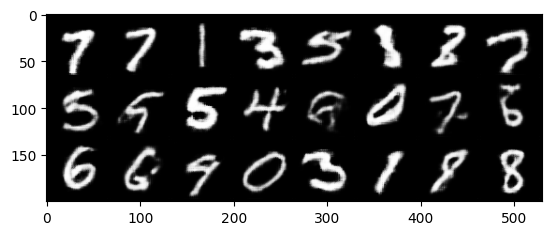

In [24]:

NUM_IMAGES = 24  # Number of images to generate

# Generate random noise and pass it through the generator
def generate_images(generator, num_images, z_dim):
    noise = torch.randn(num_images, z_dim, 1, 1).to(device)  # Generate random noise
    fake_images = generator(noise)  # Pass noise through the generator
    fake_images = fake_images * 0.5 + 0.5  # Rescale images to [0, 1] from [-1, 1]
    return fake_images

# Display the generated images
def show_images(images, num_images):
    grid = vutils.make_grid(images[:num_images], normalize=True, padding=2)
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())  # Convert to NumPy for plotting
    plt.show()

# Set the generator to evaluation mode
gen.eval()

# Generate and display images
generated_images = generate_images(gen, NUM_IMAGES, Z_DIM)
show_images(generated_images, NUM_IMAGES)